### Vr2 - Relative change between pre and post GPT

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pandas as pd
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

In [2]:
import pandas as pd
from nltk import FreqDist
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

In [3]:
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

In [4]:
# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

In [5]:
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]

df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

In [6]:
shareTrend = {'tagName' : df_share['index'], 'preGPT': df_share.iloc[:, 641:731].mean(axis = 1, skipna=True),
              'postGPT' : df_share.iloc[:, 731:].mean(axis = 1, skipna=True)}
shareTrend = pd.DataFrame(shareTrend)

In [7]:
# Convert nan to 0
shareTrend.fillna(0, inplace = True)
#shareTrend['diff'] = shareTrend['postGPT'] - shareTrend['preGPT']
shareTrend['diff'] = (shareTrend['postGPT'] - shareTrend['preGPT'])/(shareTrend['preGPT']+0.000001)

In [10]:
shareTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,diff
51952,boomerangapp,0.000000,0.05305,53050.397878
51951,nxhtml,0.000000,0.05305,53050.397878
51950,livescript,0.000000,0.05305,53050.397878
32182,leastastonishment,0.000000,0.05305,53050.397878
51949,jsonloader,0.000000,0.05305,53050.397878
...,...,...,...,...
33948,DOTnetmaui,0.030049,0.00000,-0.999967
34818,contractions,0.031993,0.00000,-0.999969
1449,usestate,0.042816,0.00000,-0.999977
670,useeffect,0.047860,0.00000,-0.999979


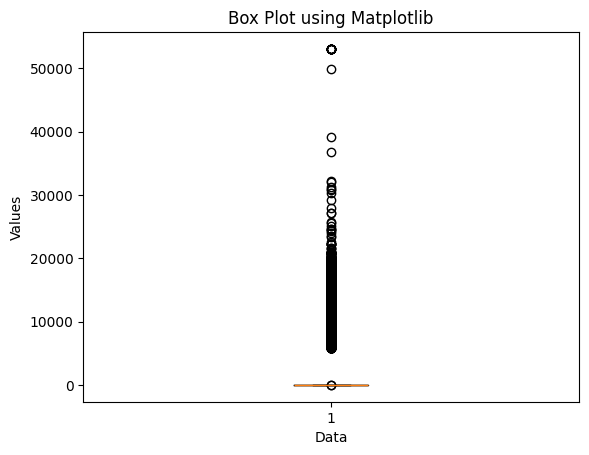

In [16]:
# Create a box plot
plt.boxplot(shareTrend['diff'])
plt.title('Box Plot using Matplotlib')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()

In [34]:
shareTrend[shareTrend['diff'] < -.8]

,tagName,preGPT,postGPT,diff
17,python,5.378989,4.561351,-0.817638


In [35]:
len(shareTrend)

51953

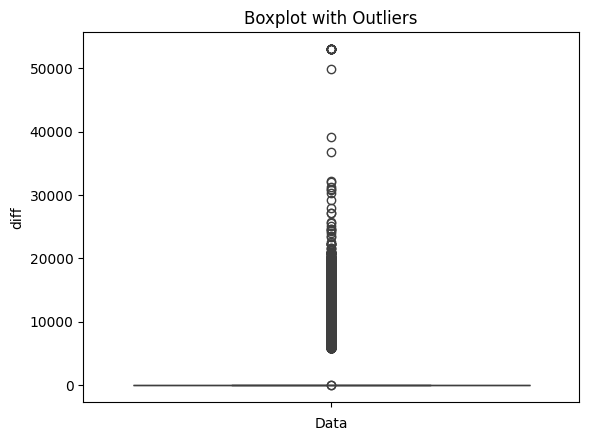

In [17]:
# Generate sample data with some random outliers
import seaborn as sns

# Create the boxplot
sns.boxplot(data=shareTrend['diff'])
plt.title("Boxplot with Outliers")
plt.xlabel("Data")
plt.show()

# Identify outliers
q1 = np.percentile(shareTrend['diff'], 25)
q3 = np.percentile(shareTrend['diff'], 75)
iqr = q3 - q1

# Outlier cutoffs
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data for outliers
outliers = shareTrend[(shareTrend['diff'] < lower_bound) | (shareTrend['diff'] > upper_bound)]
outliers

cleaned_data = shareTrend[(shareTrend['diff'] >= lower_bound) & (shareTrend['diff'] <= upper_bound)]

In [37]:
print(len(outliers))
print(len(cleaned_data))

1107
50846


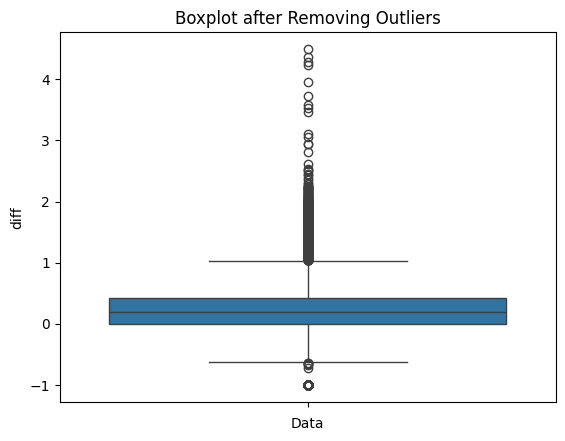

In [18]:
# Create the boxplot for the cleaned data
sns.boxplot(data=cleaned_data['diff'])
plt.title("Boxplot after Removing Outliers")
plt.xlabel("Data")
plt.show()

### Model with cleansed data

In [19]:
cleaned_data

,tagName,preGPT,postGPT,diff
0,amazonwebservices,0.425280,0.454456,0.068603
1,forloop,0.161560,0.103408,-0.359936
2,foreach,0.029891,0.024514,-0.179861
3,terraform,0.096611,0.100607,0.041364
4,awsglue,0.021343,0.028133,0.318098
...,...,...,...,...
48186,sqlite3python,0.006211,0.012917,1.079429
48187,controlbus,0.006211,0.013268,1.135977
48188,cortexr,0.006211,0.009844,0.584864
48189,xarrows,0.006211,0.009406,0.514273


In [20]:
cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)

In [21]:
cleansed

,index,tag,tag_2020_11_30,tagShare_2020_11_30,tag_2020_12_01,tagShare_2020_12_01,tag_2020_12_02,tagShare_2020_12_02,tag_2020_12_03,tagShare_2020_12_03,...,tag_2023_08_30,tagShare_2023_08_30,tag_2023_08_31,tagShare_2023_08_31,tag_2023_09_01,tagShare_2023_09_01,tag_2023_09_02,tagShare_2023_09_02,tag_2023_09_03,tagShare_2023_09_03
0,amazonwebservices,52132,47.0,0.315352,59.0,0.368819,57.0,0.352505,86.0,0.493657,...,47.0,0.409087,57.0,0.503890,38.0,0.389744,25.0,0.41625,13.0,0.689655
1,forloop,16939,19.0,0.127483,21.0,0.131275,27.0,0.166976,32.0,0.183686,...,11.0,0.095744,4.0,0.035361,4.0,0.041026,3.0,0.04995,3.0,0.159151
2,foreach,3614,9.0,0.060386,5.0,0.031256,3.0,0.018553,6.0,0.034441,...,3.0,0.026112,2.0,0.017680,1.0,0.010256,1.0,0.01665,NaN,NaN
3,terraform,11491,13.0,0.087225,12.0,0.075014,10.0,0.061843,8.0,0.045922,...,13.0,0.113152,17.0,0.150283,13.0,0.133333,2.0,0.03330,NaN,NaN
4,awsglue,2203,3.0,0.020129,5.0,0.031256,2.0,0.012369,1.0,0.005740,...,2.0,0.017408,NaN,NaN,2.0,0.020513,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39013,sqlite3python,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,0.026521,NaN,NaN,NaN,NaN,NaN,NaN
39014,controlbus,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39015,cortexr,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39016,xarrows,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2) Calculate HHI Index

In [22]:
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result
# Measure score
HHI_Score = []
# Calculate HHI for each monthly tag share column.
for i in range(3, cleansed.shape[1], 2):
    HHI_Score.append(square_sum(cleansed.iloc[:, i]))
result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

In [23]:
result_HHI

,year_month,HHI_Score
0,2020-11-30,73.910539
1,2020-12-01,72.917654
2,2020-12-02,70.724817
3,2020-12-03,68.937476
4,2020-12-04,70.566872
...,...,...
1003,2023-08-30,49.639568
1004,2023-08-31,48.329127
1005,2023-09-01,48.496621
1006,2023-09-02,59.796736


### 3) Diff-in-Diff
- Treated Group : 2022-09 ~ 2023-08 (12 months)
- Control Group : 2021-09 ~ 2022-08 (12 months)
- Diversity Ratio == HHI_Score

In [24]:
hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
# Split Data
control_data = pd.DataFrame({'HHI' : hhi[:365],
              'T_d': [0]*len(hhi[:365]),
              'P_t' : [0]*90 + [1]*275})
treated_data = pd.DataFrame({'HHI' : hhi[365:],
              'T_d': [1]*len(hhi[365:]),
              'P_t' : [0]*90 + [1]*275})
df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
# Add date and month feature
df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
df_did['month'] = pd.to_datetime(df_did['date']).dt.month
# Apply log
df_did['ln_y'] = np.log(df_did['HHI'])

### 4) Model Fitting

In [25]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.2999,0.073,59.088,0.000,4.157,4.443
C(month)[T.2],-0.0276,0.018,-1.511,0.131,-0.063,0.008
C(month)[T.3],-0.0524,0.018,-2.944,0.003,-0.087,-0.017
C(month)[T.4],-0.0176,0.018,-0.982,0.326,-0.053,0.018
C(month)[T.5],-0.0534,0.018,-3.001,0.003,-0.088,-0.018
C(month)[T.6],-0.0726,0.018,-4.043,0.000,-0.108,-0.037
C(month)[T.7],-0.0581,0.018,-3.266,0.001,-0.093,-0.023
C(month)[T.8],-0.0936,0.018,-5.260,0.000,-0.129,-0.059
C(month)[T.9],0.0294,0.074,0.400,0.689,-0.115,0.174
C(month)[T.10],0.0550,0.073,0.748,0.454,-0.089,0.199


In [26]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ln_y   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     115.1
Date:                Mon, 29 Apr 2024   Prob (F-statistic):          2.35e-172
Time:                        07:28:14   Log-Likelihood:                 659.05
No. Observations:                 730   AIC:                            -1288.
Df Residuals:                     715   BIC:                            -1219.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.2999      0.073     59.088      0.000       4.157       4.443
C(month)[T.2]     -0.0276      0.018     -1.511      0.131      -0.063       0.008
C(month)[T.3]     -0.0524      0.018     -2.944      0.003      -0.087      -0.017
C(month)[T.4]     -0.0176      0.018     -0.982      0.326      -0.053       0.018
C(month)[T.5]     -0.0534      0.018     -3.001      0.003      -0.088      -0.018
C(month)[T.6]     -0.0726      0.018     -4.043      0.000      -0.108      -0.037
C(month)[T.7]     -0.0581      0.018     -3.266      0.001      -0.093      -0.023
C(month)[T.8]     -0.0936      0.018     -5.260      0.000      -0.129      -0.059
C(month)[T.9]      0.0294      0.074      0.400      0.689      -0.115       0.174
C(month)[T.10]     0.0550      0.073      0.748      0.454      -0.089       0.199
C(month)[T.11]     0.0186      0.071      0.261      0.794      -0.121       0.158
C(month)[T.12]     0.0515      0.018      2.893      0.004       0.017       0.086
T_d               -0.0902      0.015     -6.107      0.000      -0.119      -0.061
P_t                0.0704      0.072      0.980      0.327      -0.071       0.211
T_d:P_t           -0.2160      0.017    -12.690      0.000      -0.249      -0.183
==============================================================================
Omnibus:                       49.805   Durbin-Watson:                   1.189
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.667
Skew:                           0.590   Prob(JB):                     1.64e-11
Kurtosis:                       2.509   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Alternative
- only consider diff score lower than -0.4 as outliers

In [20]:
cleaned_data = shareTrend[(shareTrend['diff'] >= -0.4)]
cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result
# Measure score
HHI_Score = []
# Calculate HHI for each monthly tag share column.
for i in range(3, cleansed.shape[1], 2):
    HHI_Score.append(square_sum(cleansed.iloc[:, i]))
result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
# Split Data
control_data = pd.DataFrame({'HHI' : hhi[:365],
              'T_d': [0]*len(hhi[:365]),
              'P_t' : [0]*90 + [1]*275})
treated_data = pd.DataFrame({'HHI' : hhi[365:],
              'T_d': [1]*len(hhi[365:]),
              'P_t' : [0]*90 + [1]*275})
df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
# Add date and month feature
df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
df_did['month'] = pd.to_datetime(df_did['date']).dt.month
# Apply log
df_did['ln_y'] = np.log(df_did['HHI'])

In [133]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.4599,0.047,73.671,0.000,3.368,3.552
C(month)[T.2],-0.0195,0.012,-1.652,0.099,-0.043,0.004
C(month)[T.3],-0.0186,0.011,-1.623,0.105,-0.041,0.004
C(month)[T.4],-0.0031,0.012,-0.268,0.789,-0.026,0.020
C(month)[T.5],-0.0028,0.011,-0.248,0.804,-0.025,0.020
C(month)[T.6],-0.0224,0.012,-1.931,0.054,-0.045,0.000
C(month)[T.7],-0.0235,0.011,-2.045,0.041,-0.046,-0.001
C(month)[T.8],-0.0360,0.011,-3.131,0.002,-0.059,-0.013
C(month)[T.9],-0.0017,0.047,-0.037,0.971,-0.095,0.091
C(month)[T.10],-0.0161,0.047,-0.339,0.735,-0.109,0.077


In [134]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ln_y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     84.99
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          1.36e-141
Time:                        16:35:00   Log-Likelihood:                 978.74
No. Observations:                 730   AIC:                            -1927.
Df Residuals:                     715   BIC:                            -1859.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4599      0.047     73.671      0.000       3.368       3.552
C(month)[T.2]     -0.0195      0.012     -1.652      0.099      -0.043       0.004
C(month)[T.3]     -0.0186      0.011     -1.623      0.105      -0.041       0.004
C(month)[T.4]     -0.0031      0.012     -0.268      0.789      -0.026       0.020
C(month)[T.5]     -0.0028      0.011     -0.248      0.804      -0.025       0.020
C(month)[T.6]     -0.0224      0.012     -1.931      0.054      -0.045       0.000
C(month)[T.7]     -0.0235      0.011     -2.045      0.041      -0.046      -0.001
C(month)[T.8]     -0.0360      0.011     -3.131      0.002      -0.059      -0.013
C(month)[T.9]     -0.0017      0.047     -0.037      0.971      -0.095       0.091
C(month)[T.10]    -0.0161      0.047     -0.339      0.735      -0.109       0.077
C(month)[T.11]    -0.0424      0.046     -0.922      0.357      -0.133       0.048
C(month)[T.12]     0.0173      0.011      1.509      0.132      -0.005       0.040
T_d               -0.1001      0.010    -10.492      0.000      -0.119      -0.081
P_t               -0.0175      0.046     -0.378      0.705      -0.108       0.073
T_d:P_t           -0.0698      0.011     -6.354      0.000      -0.091      -0.048
==============================================================================
Omnibus:                       55.184   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.643
Skew:                           0.736   Prob(JB):                     3.38e-15
Kurtosis:                       2.853   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Aditional Figures

In [ ]:
import plotly.express as px


# Create an interactive box plot
fig = px.box(shareTrend['diff'], points="all", title="Avg. Tag Share Comparison (PreGPT Vs. PostGPT)",
             hover_data = [shareTrend['tagName']])
fig.update_layout(height=600)


# Show the plot
fig.show()

In [22]:
df_count.columns.get_loc('tag_2022_11_30')

731

In [24]:
df_count.columns.get_loc('tag_2023_09_03')

1008

In [23]:
1009-731

278

In [ ]:
# tag_2020_11_30 -> tag2023_09_03
# release of chatGPT -> November 30, 2022

In [9]:
all_keys

,index,tag
0,amazonwebservices,52132
1,forloop,16939
2,foreach,3614
3,terraform,11491
4,awsglue,2203
...,...,...
51948,applespeech,1
51949,jsonloader,1
51950,livescript,1
51951,nxhtml,1


In [ ]:
# 변동폭이 높았던 순으로 나열
# 3개 정도의 partion으로 자르기.
# 각각의 partition에 대해 DiD 계산.